## Operability Analysis of a Membrane Reactor for Methane Aromatizaion and Hydrogen Production

This case study consists of a membrane reactor for direct methane aromatization (DMA-MR)
that allows hydrogen and benzene production from natural gas. This single unit operation
is capable of performing reaction and separation simultaneously, allowing for achieving
higher conversion of hydrogen due to Le'Chatelier's principle.

The DMA-MR model has been extensively studied in process operability analysis due to
its particular potential for system modularization and process intensification, as well as
the challenging modeling due to its inherent nonlinearity.

In this case study, some of pypo's feature are highlighted, such as:

-  Inverse mapping using state-of-the-art nonlinear programming solvers (e.g., Ipopt)
-  Support for automatic differentiation
-  Evaluation of operability sets for design and control objectives.

In [1]:
import jax.numpy as np
from jax.numpy import pi as pi
from jax.experimental.ode import odeint

Defining the Kinetic and general parameters for the DMA-MR model

In [2]:
# Kinetic and general parameters

R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s-¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s-¹]
k2_Inv = 56.38              # [cm³/s-mol]

    
# Molecular weights
MM_B = 78.00     #[g/mol] 

# Fixed Reactor Values
T = 1173.15                 # Temperature[K]  =900[°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa](1atm)
v0 = 3600 * (2 / 15)        # Vol. Flowrate [cm³ h-¹]
Ft0 = Pt * v0 / (R * T)     # Initial molar flowrate[mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa](1atm)
ds = 3                      # Diameter[cm]
v_He = 3600 * (1 / 6)       # Vol. flowrate[cm³/h]
F_He = Ps * v_He / (R * T)  # Sweep gas molar flowrate [mol/h]

Defining the DMA-MR Model equations (mol balances), compatible with Google's JAX:

In [3]:
def dma_mr_model(F, z, dt):

    At = 0.25 * np.pi * (dt ** 2)  # Cross sectional area[cm³]
    
    # Avoid negative flows that can happen in the first integration steps.
    # Consequently this avoids that any molar balance (^ 1/4 terms) generates
    # complex numbers.
    F = np.where(F <= 1e-9, 1e-9, F)
    

    
    # Evaluate total flowrate in tube & shell.
    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v = v0 * (Ft / Ft0)

    # Concentrations from molar flowrates [mol/cm3]
    C = F[:4] / v
    # Partial pressures - Tube & Shell [mol/cm3]

    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)

    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)
    
    

    
    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2] ** 2) / 
                                  (k1 * (C[0])**2 )))
    

    # This replicates an if statement whenever the concentrations are near zero
    C0_aux = C[0]
    r0 = np.where(C0_aux <= 1e-9, 0, r0)
    
    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2] ** 3) / 
                                  (k2 * (C[1])**3 )))
    

    # Same as before
    C1_aux = C[1]
    r1 = np.where(C1_aux <= 1e-9 , 0, r1)  

    # Molar balances adjustment with experimental data.
    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    # Molar balances dFdz - Tube (0 to 3) & Shell (4 to 7)
    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF1 = 1 / 2 * Cat * r0 * At - Cat * r1 * At - (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF2 = Cat * r0 * At + Cat * r1 * At- (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF3 = (1 / 3) * Cat * r1 * At - (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    dF4 = (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF5 = (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF6 = (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF7 = (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    
    dFdz = np.array([ dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7 ])

    return dFdz

### Analyzing a modular design region using operability inverse mapping

Defining the outputs based on the integration of the DMA-MR model equations.

AIS/DIS Variables:
- Length [cm]
- Diameter [cm]

AOS/DOS Variables:
- Methane conversion [%]
- Benzene production [mg/h]

In [4]:
def dma_mr_design(u):

    L =  u[0]
    dt = u[1]

    # Initial conditions
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances using Jax's Dormand Prince
    z = np.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt, rtol=rtol, atol=atol)
    
    # Calculating outputs (AOS/DOS) from states.
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    return np.array([F_C6H6, X_CH4])

Importing pypo's inverse mapping (NLP-based)

In [5]:
from pypo import nlp_based_approach

Definition of operability sets and its bounds

In [10]:
# Lower and upper bounds for DOS definition
DOS_bounds = np.array([[15,25],
                       [35,45]])

# Discretization Grid - 10x10 grid for DOS.
DOS_resolution =  [10, 10]

# Lower and upper bounds of AIS design variables.
lb = np.array([10,  0.1])
ub = np.array([300, 2])

# Initial estimate for NLP.
u0 = np.array([50, 1])

In [11]:
import time

Defining a nonlinear constraint $L/D \geq 30 $ to the inverse mapping to guarantee
plug-flow operation

In [12]:
# Plug-flow constraint definition: Length/Diameter >= 30.
def plug_flow(u):
    return u[0] - 30.0*u[1]

con= {'type': 'ineq', 'fun': plug_flow}

Obtaining the feasible desired input/output sets $(DIS^*/DOS^*)$ at each discretized point

 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian). Make sure your process model is JAX-compatible implementation-wise.


100%|██████████| 100/100 [05:26<00:00,  3.27s/it]


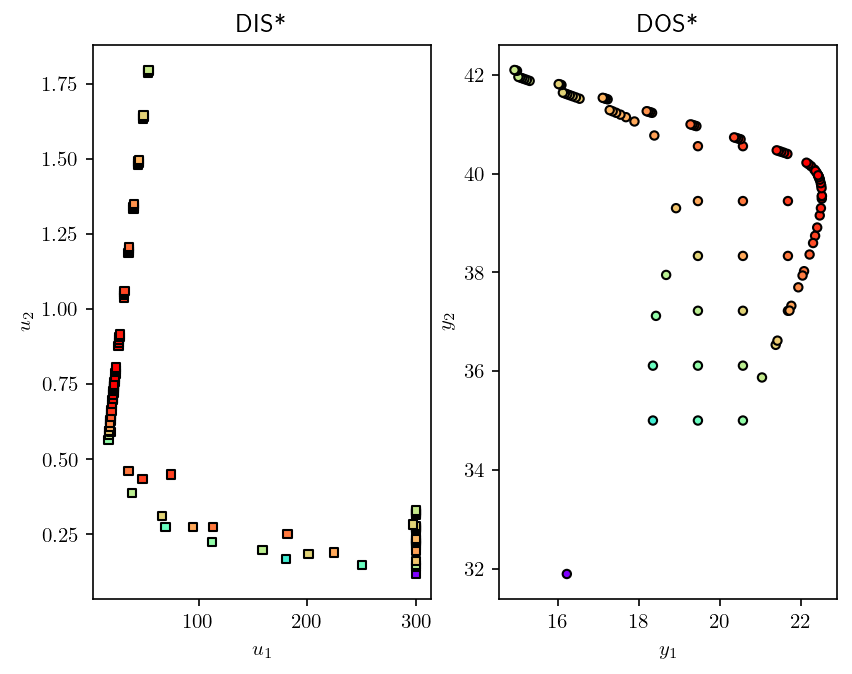

In [13]:
# Model assignment: Design Problem - Inverse mapping
# model          = dma_mr_design
# Obtain inverse mapping.
t = time.time()                                                  
fDIS, fDOS, convergence = nlp_based_approach(DOS_bounds, 
                                             DOS_resolution,
                                             dma_mr_design, 
                                             u0,
                                             lb,
                                             ub,
                                             constr=(con),
                                             method='ipopt',
                                             plot=True,
                                             ad=True,
                                             warmstart=True)
elapsed = time.time() - t

The inverse mapping shows that there is a design region of tube length around  0.5cm and tube
diameter of 17cm that can still attains to the requirement of the DOS.

### Analyzing the Operability Index (OI) for operational changes (manipulated variables)

With a fixed modular design of 
- Tube length = 17 cm
- Tube diameter = 0.5 cm

The manipulated variables of the DMA-MR (namely, shell and tube flow rates) are
to be analyzed, being the AIS variables for this analysis. As before, the same 
AOS/DOS variables will be kept to observe if the system is operable under the fixed
modular design and varying the manipulated variable throughout their available range.